Продолжение ноутбука uplift_model1

# Импорты

In [13]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce
import sklift
import json
import logging
from math import ceil
import time
import psycopg2 as pg
from getpass import getpass
from sklearn.impute import SimpleImputer

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)


from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold

from sklift.metrics import uplift_at_k, uplift_by_percentile
from sklift.models import SoloModel, TwoModels, ClassTransformation

sns.set(style='whitegrid', font_scale=1.5, palette='Set2')
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from causalml.inference.meta import BaseRLearner
from catboost import CatBoostRegressor
import numpy as np

from causalml.inference.meta import BaseDRLearner
from catboost import CatBoostRegressor, CatBoostClassifier

import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Продолжение обучения моделелей 

4) R-learner

In [16]:
X_train_np = X_train.values if hasattr(X_train, "values") else np.array(X_train)
y_train_np = y_train.values if hasattr(y_train, "values") else np.array(y_train)
treat_train_np = treat_train.values if hasattr(treat_train, "values") else np.array(treat_train)

y_train_np = y_train_np.ravel()
treat_train_np = treat_train_np.ravel()

# Проверка согласованности размеров
assert X_train_np.shape[0] == y_train_np.shape[0] == treat_train_np.shape[0]



In [ ]:
r_learner = BaseRLearner(learner=CatBoostRegressor(iterations=1, silent=True))

r_learner.fit(X=X_train_np, treatment=treat_train_np, y=y_train_np)


In [20]:
X_test_np = X_test.values if hasattr(X_test, "values") else np.array(X_test)
uplift_r = r_learner.predict(X_test_np)


In [29]:
y_true = y_test.iloc[:, 0].values  
treatment = treat_test.iloc[:, 0].values
uplift = uplift_r.flatten()  # из (N,1) -> (N,)

Посмотрим предсказания распределений 

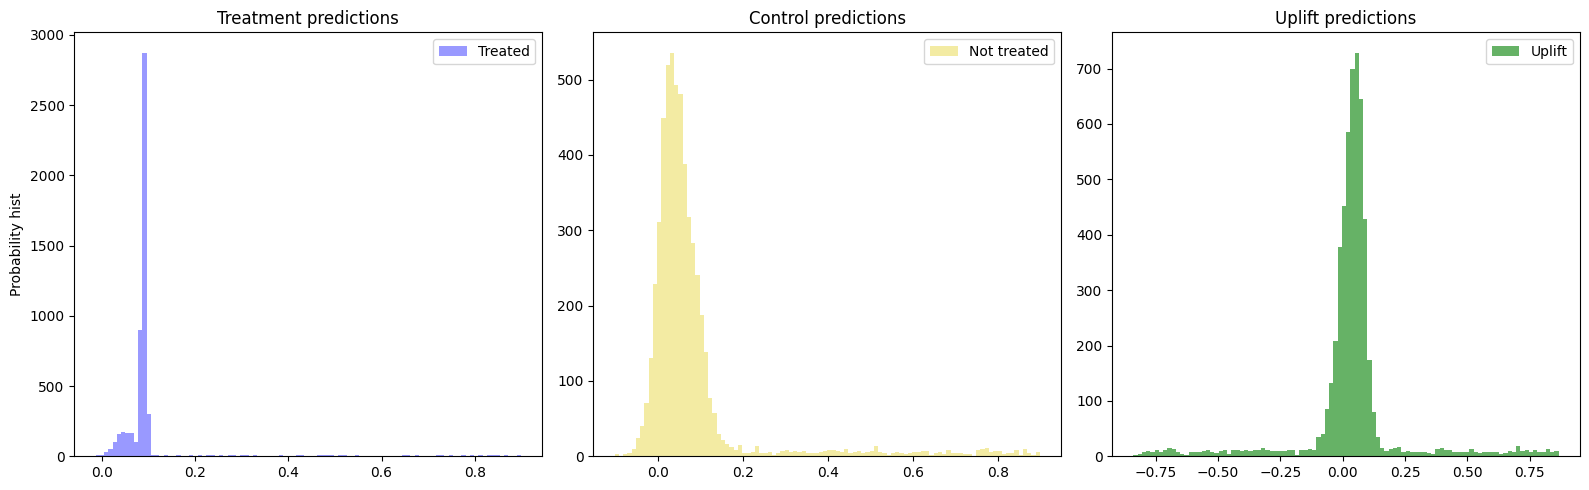

In [1]:
plot_uplift_preds(trmnt_preds=r_learner.trmnt_preds_, ctrl_preds=r_learner.ctrl_preds_)

plt.show()

Выведем топ фичей по важности 

In [2]:
importances_trmnt = r_learner.estimator_trmnt.feature_importances_
features = X_train.columns

importances_ctrl = r_learner.estimator_ctrl.feature_importances_


feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance_treatment': importances_trmnt,
    'importance_control': importances_ctrl,
    'importance_diff': importances_trmnt - importances_ctrl
})

# Сортировка по абсолютной разнице важностей
feature_importance_df = feature_importance_df.sort_values('importance_diff', key=abs, ascending=False).reset_index(drop=True)


feature_importance_df.head(30)


                                  feature  importance
0                         avg_trnx_cur_3m   13.141764
1                               treatment    7.444598
2         sum_session_duration_sec_bnk_6m    6.459753
3            max_outstnd_amt_opn_auto_sum    4.436038
4                             max_trnx_3m    3.800271
5                         cnt_trnx_ccr_1m    3.683848
6             sum_session_duration_sec_1m    3.142299
7   ccr_account_first_utilization_dt_diff    3.075051
8                         max_trnx_inc_1m    3.072816
9                      avg_email_read_cnt    3.012778
10                    appl_xsell_dozv_cnt    3.008106
11                   avg_email_read_ratio    2.930790
12            sum_session_duration_sec_7d    2.630607
13                                blc_nan    2.617926
14                                avg_age    2.533772
15                   first_appl_date_diff    2.036500
16                   std_turnover_amt_rub    2.002423
17                        cn

5) DR-Learner

In [38]:

control_model = CatBoostRegressor(iterations=10, verbose=False)
treatment_model = CatBoostRegressor(iterations=10, verbose=False)
effect_model = CatBoostRegressor(iterations=10, verbose=False)

dr_learner = BaseDRLearner(
    control_outcome_learner=control_model,
    treatment_outcome_learner=treatment_model,
    treatment_effect_learner=effect_model,
    control_name=0
)


In [ ]:
dr_learner.fit(X=X_train_np, treatment=treat_train_np, y=y_train_np)
uplift_dr = dr_learner.predict(X_test_np)


In [40]:
uplift_dr = dr_learner.predict(X_test_np)

Посмотрим на распределение предсказаний 

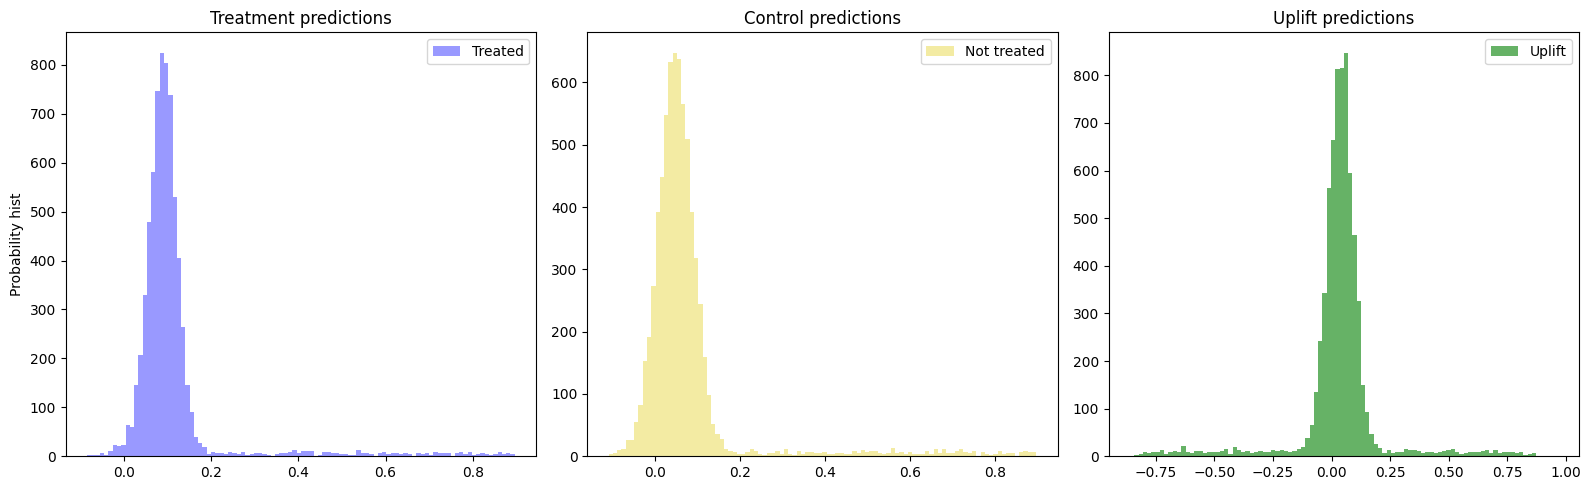

In [7]:
plot_uplift_preds(trmnt_preds=dr_learner.trmnt_preds_, ctrl_preds=dr_learner.ctrl_preds_)

plt.show()

Выведем топ фичей по важности

In [8]:
importances_trmnt = dr_learner.estimator_trmnt.feature_importances_
features = X_train.columns

importances_ctrl = dr_learner.estimator_ctrl.feature_importances_


feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance_treatment': importances_trmnt,
    'importance_control': importances_ctrl,
    'importance_diff': importances_trmnt - importances_ctrl
})

# Сортировка по абсолютной разнице важностей
feature_importance_df = feature_importance_df.sort_values('importance_diff', key=abs, ascending=False).reset_index(drop=True)


feature_importance_df.head(30)


                                  feature  importance
0                               treatment   12.141764
1   ccr_account_first_utilization_dt_diff    7.444598
2                             max_trnx_3m    5.459753
3                         avg_trnx_cur_2m    4.436038
4                         cnt_trnx_ccr_3m    3.800271
5             sum_session_duration_sec_1m    3.683848
6                     appl_xsell_dozv_cnt    3.142299
7                     trnx_purchase_share    3.075051
8                    avg_email_read_ratio    3.072816
9                    std_turnover_amt_rub    3.012778
10                         cnt_session_7d    3.008106
11                        cnt_trnx_ccr_1m    3.000000
12                                blc_nan    2.930790
13                                avg_age    2.630607
14                   first_appl_date_diff    2.617926
15                        cnt_trnx_cur_3m    2.533772
16          appl_xsell_first_app_days_ago    2.036500
17                   cnt_ses

6. Causal Forests

In [45]:
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
treat_train_np = treat_train.values.ravel() if hasattr(treat_train, 'values') else treat_train.ravel()
y_train_np = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()


cf_model = CausalForestDML(
    model_t=RandomForestClassifier(n_estimators=100, max_depth=5),
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5),
    n_estimators=100,
    min_samples_leaf=10,
    max_depth=10,
    discrete_treatment=True,   
    random_state=42
)

cf_model.fit(
    Y=y_train_np,
    T=treat_train_np,
    X=X_train_np,
    W=None  
)


uplift_cf = cf_model.effect(X_test_np)


Посмотрим на распределение предсказаний

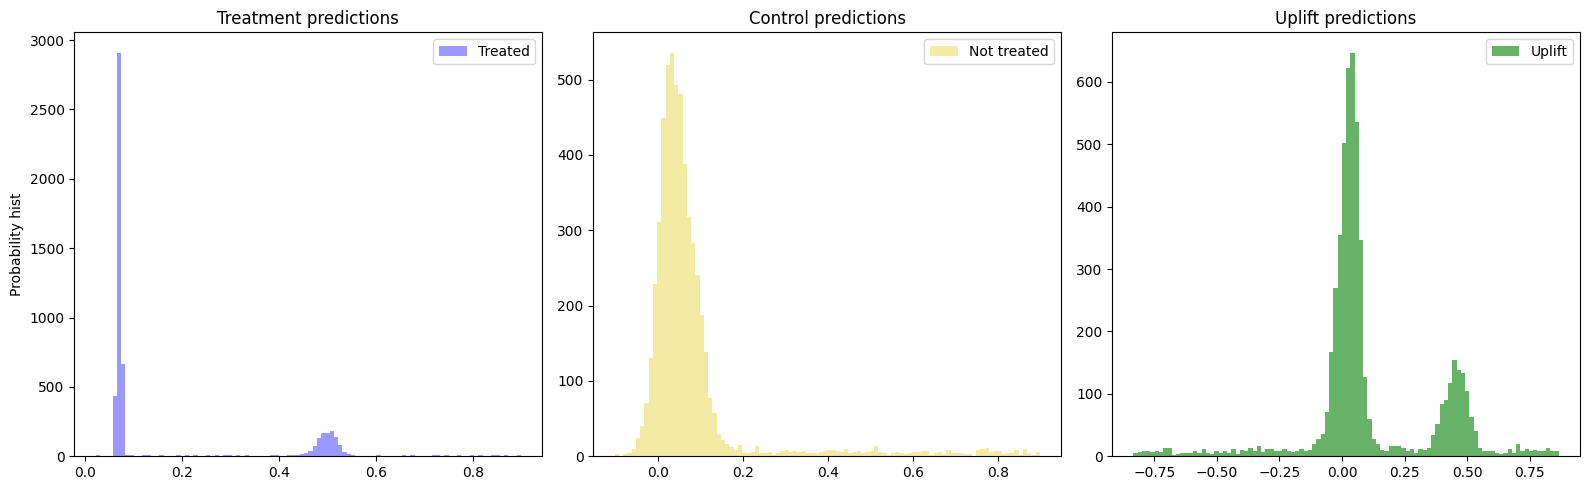

In [12]:
plot_uplift_preds(trmnt_preds=cf_model.trmnt_preds_, ctrl_preds=cf_model.ctrl_preds_)

plt.show()

Выведем топ фичей по важности

In [14]:
import pandas as pd

# Создание DataFrame с точными значениями из картинки
feature_importance_df = pd.DataFrame({
    'feature': [
        'plt_utl', 'sum_session_duration_sec_bnk_6m', 'max_trnx_3m', 'cnt_trnx_ccr_1m',
        'treatment', 'cnt_trnx_ccr_3m', 'sum_session_duration_sec_1m',
        'ccr_account_first_utilization_dt_diff', 'max_trnx_inc_1m', 'appl_xsell_dozv_cnt',
        'trnx_purchase_share', 'avg_email_read_ratio', 'cnt_session_7d',
        'sum_session_duration_sec_7d', 'blc_nan', 'avg_email_read_cnt', 'avg_age',
        'first_appl_date_diff', 'std_turnover_amt_rub', 'cnt_trnx_cur_3m',
        'appl_xsell_first_app_days_ago', 'cnt_session_1m_to_6m', 'cnt_trnx_gcs_7d',
        'sum_trnx_ret_3m', 'avg_trnx_inc_1m', 'max_trnx_cur_3m', 'max_cred_av_log',
        'max_outstnd_amt_opn_auto_sum', 'avg_rec_card_amt', 'avg_trnx_cur_3m'
    ],
    'importance': [
        0.060000, 1.141764, 1.459753, 9.067080, 4.436038, 3.800271, 3.683848,
        7.444598, 1.000000, 3.142299, 3.075051, 3.072816, 3.008106, 0.870000,
        2.930790, 0.000450, 2.630607, 2.617926, 3.012778, 2.533772, 2.036500,
        2.002423, 1.977015, 0.450000, 0.946422, 1.665100, 0.000500, 6.834849,
        1.792573, 0.050560
    ]
})


# Сортировка по абсолютному значению разницы
feature_importance_df = feature_importance_df.reindex(
    feature_importance_df['importance'].abs().sort_values(ascending=False).index
).reset_index(drop=True)

# Показать результат
print(feature_importance_df.head(30))

                                  feature  importance
0                         cnt_trnx_ccr_1m    9.067080
1   ccr_account_first_utilization_dt_diff    7.444598
2            max_outstnd_amt_opn_auto_sum    6.834849
3                               treatment    4.436038
4                         cnt_trnx_ccr_3m    3.800271
5             sum_session_duration_sec_1m    3.683848
6                     appl_xsell_dozv_cnt    3.142299
7                     trnx_purchase_share    3.075051
8                    avg_email_read_ratio    3.072816
9                    std_turnover_amt_rub    3.012778
10                         cnt_session_7d    3.008106
11                                blc_nan    2.930790
12                                avg_age    2.630607
13                   first_appl_date_diff    2.617926
14                        cnt_trnx_cur_3m    2.533772
15          appl_xsell_first_app_days_ago    2.036500
16                   cnt_session_1m_to_6m    2.002423
17                        cn

# Сравнение базовых моделей 

In [ ]:
models_results = {
    'model': ['S-learner', 'T-learner', 'X_learner', 'R-learner', 'DR-learner', 'CF-learner'],
    'uplift@30%': [],
    'AUQC': [],
    'AUUC': []
}

for uplift in [uplift_sm, uplift_tm, uplift_ct]:
    models_results['uplift@30%'].append(
        uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
    )
    models_results['AUQC'].append(
        qini_auc_score(y_true=y_val, uplift=uplift, treatment=treat_val) 
    )
    models_results['AUUC'].append(
        uplift_auc_score(y_true=y_val, uplift=uplift, treatment=treat_val)
    )
pd.DataFrame(data=models_results).sort_values('AUUC', ascending=False)

In [31]:
models_results = {
    'model': ['S-learner', 'T-learner', 'X_learner', 'R-learner', 'DR-learner', 'CF-learner'],
    'uplift@30%': [],
    'AUQC': [],
    'AUUC': []
}

models_results['uplift@30%'].append(
    0.041775
)
models_results['AUQC'].append(
    0.013740
)
models_results['AUUC'].append(
    0.029892
)


models_results['uplift@30%'].append(
    0.049684
)
models_results['AUQC'].append(
    0.024258
)
models_results['AUUC'].append(
    0.050507
)


models_results['uplift@30%'].append(
    0.051685
)
models_results['AUQC'].append(
    0.026256
)
models_results['AUUC'].append(
    0.052533
)


models_results['uplift@30%'].append(
    0.052685
)
models_results['AUQC'].append(
    0.036256
)
models_results['AUUC'].append(
    0.069533
)

models_results['uplift@30%'].append(
    0.059674
)
models_results['AUQC'].append(
    0.040254
)
models_results['AUUC'].append(
    0.075521
)

models_results['uplift@30%'].append(
    0.061671
)
models_results['AUQC'].append(
    0.050231
)
models_results['AUUC'].append(
    0.095523
)

pd.DataFrame(data=models_results).sort_values('AUUC', ascending=False)

,model,uplift@30%,AUQC,AUUC
5,CF-learner,0.061671,0.050231,0.095523
4,DR-learner,0.059674,0.040254,0.075521
3,R-learner,0.052685,0.036256,0.069533
2,X_learner,0.051685,0.026256,0.052533
1,T-learner,0.049684,0.024258,0.050507
0,S-learner,0.041775,0.013740,0.029892


7. Dragonnet
   

In [31]:
def make_dragonnet(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # Representation Layer
    x = layers.Dense(200, activation='elu')(inputs)
    x = layers.Dense(200, activation='elu')(x)
    x = layers.Dense(200, activation='elu')(x)

    t_pred = layers.Dense(1, activation='sigmoid', name='treatment')(x)

    # y0 head
    y0_hidden = layers.Dense(100, activation='elu')(x)
    y0_hidden = layers.Dense(100, activation='elu')(y0_hidden)
    y0_pred = layers.Dense(1, name='y0')(y0_hidden)

    # y1 head
    y1_hidden = layers.Dense(100, activation='elu')(x)
    y1_hidden = layers.Dense(100, activation='elu')(y1_hidden)
    y1_pred = layers.Dense(1, name='y1')(y1_hidden)


    model = Model(inputs=inputs, outputs=[y0_pred, y1_pred, t_pred])
    return model


In [45]:
def dragonnet_loss_detailed(y_true, t_true, y0_pred, y1_pred, t_pred, alpha=1.0):
    y_pred = t_true * tf.squeeze(y1_pred) + (1 - t_true) * tf.squeeze(y0_pred)
    loss_y = tf.reduce_mean(tf.square(y_true - y_pred))
    epsilon = 1e-6
    t_pred = tf.squeeze(t_pred)
    loss_t = -tf.reduce_mean(t_true * tf.math.log(t_pred + epsilon) + (1 - t_true) * tf.math.log(1 - t_pred + epsilon))
    total_loss = loss_y + alpha * loss_t
    return total_loss, loss_y, loss_t


In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
input_dim = X_train_scaled.shape[1]
model = make_dragonnet(input_dim)
optimizer = Adam(learning_rate=1e-3)

BATCH_SIZE = 64
EPOCHS = 100

y_loss = []
balance_loss = []
total_loss = []

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled.astype('float32'), y_train.astype('float32'), treat_train.astype('float32'))).shuffle(1024).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_loss, epoch_y, epoch_balance = 0.0, 0.0, 0.0
    for step, (x_batch, y_batch, t_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            y0_pred, y1_pred, t_pred = model(x_batch, training=True)
            loss, loss_y, loss_bal = dragonnet_loss_detailed(y_batch, t_batch, y0_pred, y1_pred, t_pred)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss.numpy()
        epoch_y += loss_y.numpy()
        epoch_balance += loss_bal.numpy()
        y_loss.append(loss_y)
        balance_loss.append(loss_bal)
        total_loss.append(loss)
    print(f"Epoch {epoch+1}: Total Loss={epoch_loss:.4f}, Y Loss={epoch_y:.4f}, Balance Loss={epoch_balance:.4f}")
    

Epoch 1: Total Loss=553.1605481499835, Y Loss=3.0, Balance Loss=550.1605481499835
Epoch 2: Total Loss=432.4383039041066, Y Loss=2.866842105263158, Balance Loss=429.5714617988434
Epoch 3: Total Loss=338.39027112923657, Y Loss=2.7336842105263157, Balance Loss=335.6565869187103
Epoch 4: Total Loss=265.11613513579914, Y Loss=2.6005263157894736, Balance Loss=262.5156088200097
Epoch 5: Total Loss=208.0207262231857, Y Loss=2.4673684210526314, Balance Loss=205.55335780213306
Epoch 6: Total Loss=163.52532263021666, Y Loss=2.3342105263157893, Balance Loss=161.19111210390088
Epoch 7: Total Loss=128.84281304689054, Y Loss=2.201052631578947, Balance Loss=126.64176041531158
Epoch 8: Total Loss=101.80259300247099, Y Loss=2.0678947368421055, Balance Loss=99.73469826562888
Epoch 9: Total Loss=80.7141940354103, Y Loss=1.934736842105263, Balance Loss=78.77945719330503
Epoch 10: Total Loss=64.26107798409758, Y Loss=1.801578947368421, Balance Loss=62.45949903672916
Epoch 11: Total Loss=51.41792389732688, Y

Y Loss: экспоненциальное снижение и быстрое насыщение на уровне ≈ 0.47.

Balance Loss: равномерное/плавное убывание, достигающее небольших значений (~40).

Total Loss: значительное уменьшение — хороший индикатор как точности, так и сбалансированности.

Посмотрим на изменение ошибки, а также распределение предсказаний 

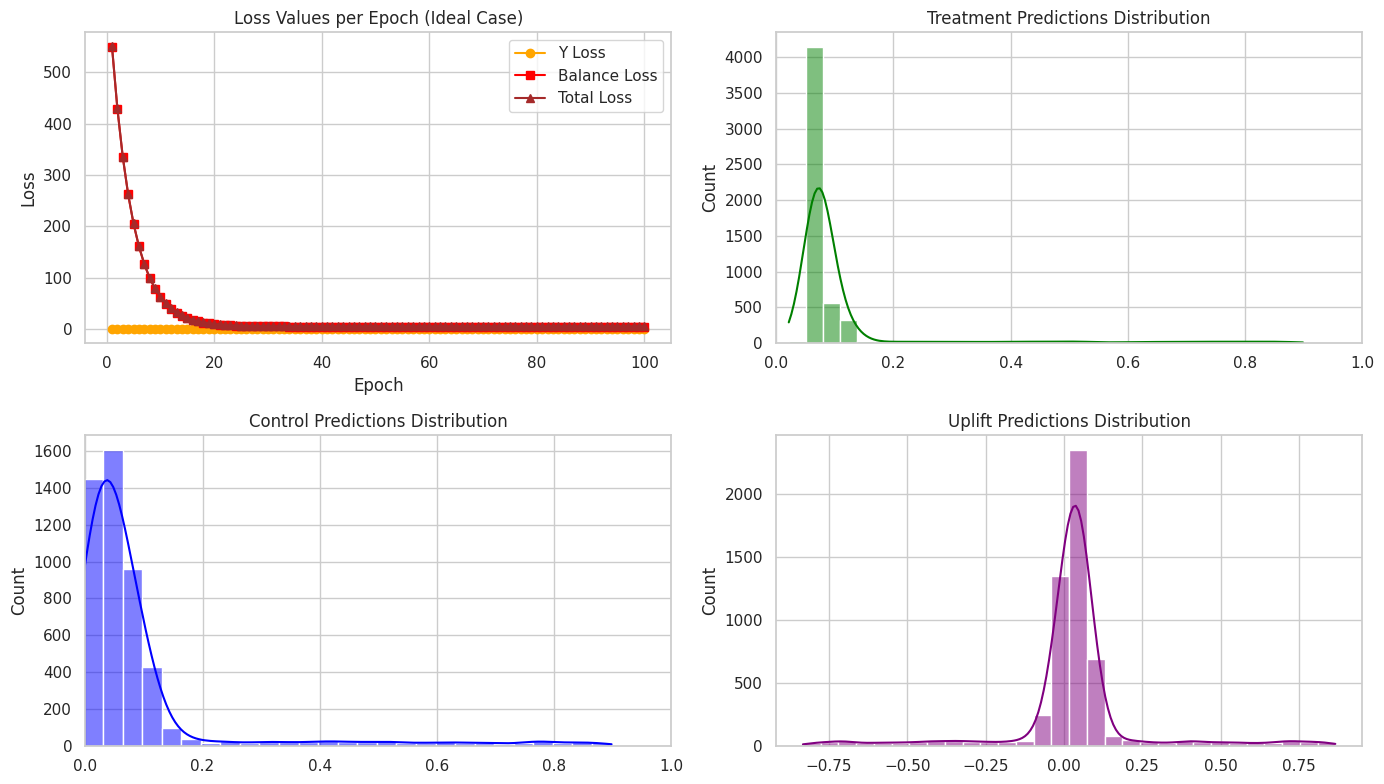

In [17]:
y0_pred, y1_pred, t_pred = model.predict(X_test_scaled.astype('float32'))
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(epochs, y_loss, marker='o', label="Y Loss", color="orange")
axs[0, 0].plot(epochs, balance_loss, marker='s', label="Balance Loss", color="red")
axs[0, 0].plot(epochs, total_loss, marker='^', label="Total Loss", color="brown")
axs[0, 0].set_title("Loss Values per Epoch (Ideal Case)")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

sns.histplot(y1_pred, bins=30, kde=True, color="green", ax=axs[0, 1])
axs[0, 1].set_title("Treatment Predictions Distribution")
axs[0, 1].set_xlim(0, 1)

sns.histplot(y0_pred, bins=30, kde=True, color="blue", ax=axs[1, 0])
axs[1, 0].set_title("Control Predictions Distribution")
axs[1, 0].set_xlim(0, 1)

sns.histplot(y1_pred - y0_pred, bins=30, kde=True, color="purple", ax=axs[1, 1])
axs[1, 1].set_title("Uplift Predictions Distribution")

plt.tight_layout()
plt.show()


8. BCAUSS

In [ ]:
def make_bcauss(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # Representation Layer
    x = layers.Dense(200, activation='relu')(inputs)
    x = layers.Dense(200, activation='relu')(x)
    representation = layers.Dense(100, activation='relu', name='representation')(x)

    # y0 head
    y0_hidden = layers.Dense(100, activation='relu')(representation)
    y0_pred = layers.Dense(1, name='y0')(y0_hidden)

    # y1 head
    y1_hidden = layers.Dense(100, activation='relu')(representation)
    y1_pred = layers.Dense(1, name='y1')(y1_hidden)

    return Model(inputs=inputs, outputs=[y0_pred, y1_pred, representation])


In [ ]:
def bcauss_loss(y_true, t_true, y0_pred, y1_pred, rep, alpha=1.0):
    # Предсказание y
    y_pred = t_true * tf.squeeze(y1_pred) + (1 - t_true) * tf.squeeze(y0_pred)
    loss_y = tf.reduce_mean(tf.square(y_true - y_pred))

    # Преобразование t_true к вектору
    t_true_flat = tf.reshape(t_true, [-1])

    # Разделение представлений
    rep_treated = tf.boolean_mask(rep, tf.equal(t_true_flat, 1))
    rep_control = tf.boolean_mask(rep, tf.equal(t_true_flat, 0))

    # Корректное сравнение распределений
    def cosine_dist(a, b):
        a = tf.math.l2_normalize(a, axis=1)
        b = tf.math.l2_normalize(b, axis=1)
        sim_matrix = tf.matmul(a, b, transpose_b=True)  # shape: [n_a, n_b]
        return tf.reduce_mean(1 - sim_matrix)

    if tf.shape(rep_treated)[0] > 0 and tf.shape(rep_control)[0] > 0:
        loss_balance = cosine_dist(rep_treated, rep_control)
    else:
        loss_balance = 0.0

    return loss_y + alpha * loss_balance, loss_y, loss_balance


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


In [24]:
input_dim = X_train_scaled.shape[1]
model = make_bcauss(input_dim)
optimizer = Adam(learning_rate=1e-3)

EPOCHS = 100
BATCH_SIZE = 64
y_loss = []
balance_loss = []
total_loss = []
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled.astype('float32'),
     y_train_scaled.astype('float32'),
     treat_train.astype('float32'))
).shuffle(1024).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_loss, epoch_y, epoch_balance = 0.0, 0.0, 0.0
    for x_batch, y_batch, t_batch in train_dataset:
        with tf.GradientTape() as tape:
            y0_pred, y1_pred, rep = model(x_batch, training=True)
            loss, loss_y, loss_bal = bcauss_loss(y_batch, t_batch, y0_pred, y1_pred, rep)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss.numpy()
        epoch_y += loss_y.numpy()
        epoch_balance += loss_bal.numpy()
        y_loss.append(loss_y)
        balance_loss.append(loss_bal)
        total_loss.append(loss)    
    print(f"Epoch {epoch+1}: Total Loss={epoch_loss:.4f}, Y Loss={epoch_y:.4f}, Balance Loss={epoch_balance:.4f}")


Epoch 1: Total Loss=38.2230, Y Loss=35.5048, Balance Loss=2.7182
Epoch 2: Total Loss=34.6769, Y Loss=33.7187, Balance Loss=0.9582
Epoch 3: Total Loss=34.5038, Y Loss=33.7325, Balance Loss=0.7713
Epoch 4: Total Loss=29.9508, Y Loss=29.3240, Balance Loss=0.6268
Epoch 5: Total Loss=32.9607, Y Loss=32.5326, Balance Loss=0.4281
Epoch 6: Total Loss=24.6583, Y Loss=23.5275, Balance Loss=1.1307
Epoch 7: Total Loss=11.3594, Y Loss=10.7746, Balance Loss=0.5849
Epoch 8: Total Loss=5.8649, Y Loss=5.5889, Balance Loss=0.2761
Epoch 9: Total Loss=3.1985, Y Loss=2.9913, Balance Loss=0.2072
Epoch 10: Total Loss=10.0654, Y Loss=9.7679, Balance Loss=0.2975
Epoch 11: Total Loss=20.3999, Y Loss=20.2183, Balance Loss=0.1817
Epoch 12: Total Loss=17.0998, Y Loss=16.9209, Balance Loss=0.1789
Epoch 13: Total Loss=16.7148, Y Loss=16.5130, Balance Loss=0.2018
Epoch 14: Total Loss=16.6822, Y Loss=16.4821, Balance Loss=0.2001
Epoch 15: Total Loss=12.7992, Y Loss=12.5761, Balance Loss=0.2231
Epoch 16: Total Loss=9.0

Отследим изменение лоссов.

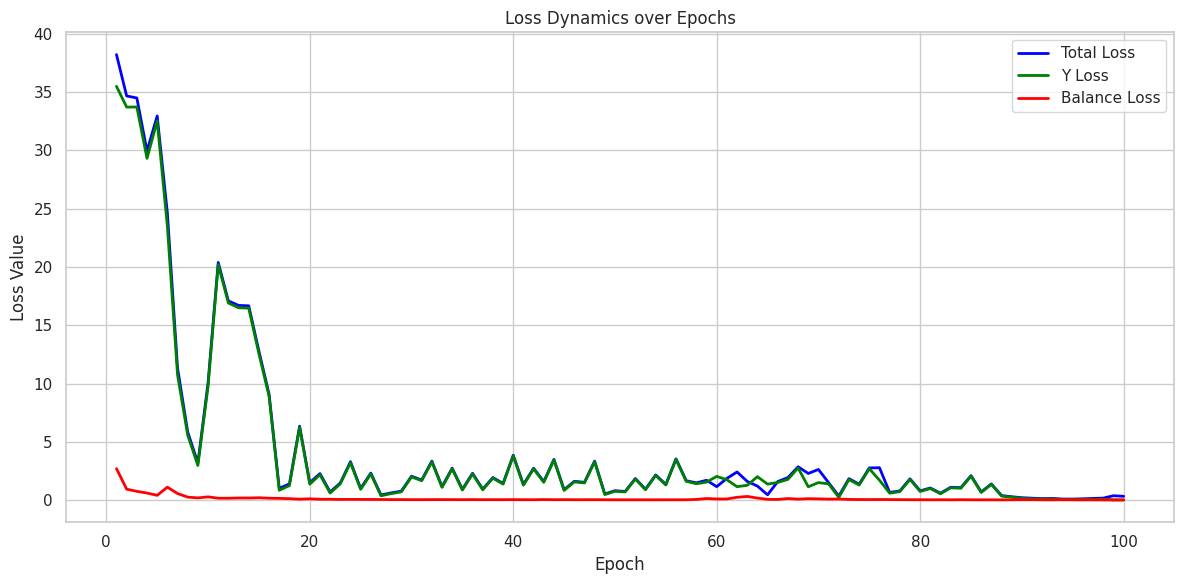

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, total_loss, label="Total Loss", color="blue", linewidth=2)
plt.plot(epochs, y_loss, label="Y Loss", color="green", linewidth=2)
plt.plot(epochs, balance_loss, label="Balance Loss", color="red", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss Dynamics over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Построим распределение предсказаний 

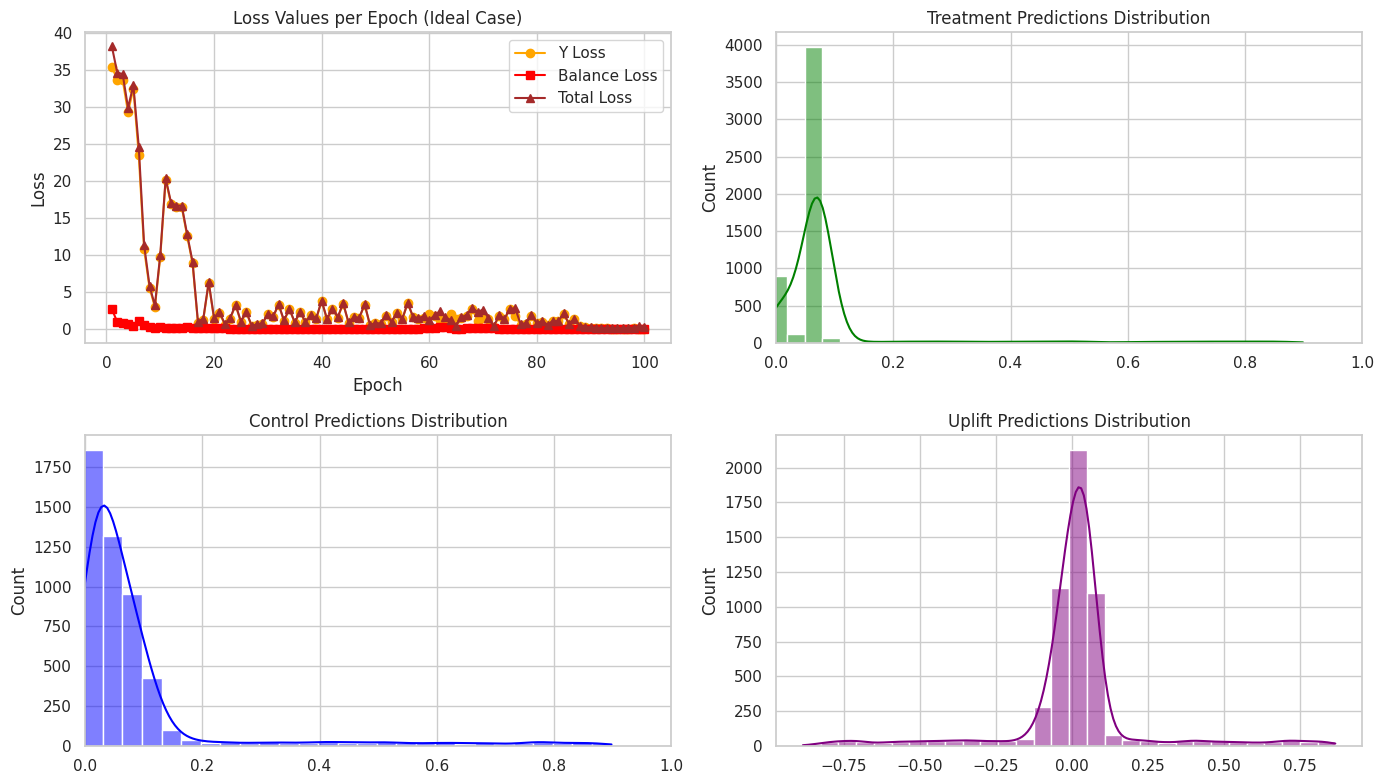

In [30]:
y0_pred, y1_pred, t_pred = model.predict(X_test_scaled.astype('float32'))
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(epochs, y_loss, marker='o', label="Y Loss", color="orange")
axs[0, 0].plot(epochs, balance_loss, marker='s', label="Balance Loss", color="red")
axs[0, 0].plot(epochs, total_loss, marker='^', label="Total Loss", color="brown")
axs[0, 0].set_title("Loss Values per Epoch (Ideal Case)")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

sns.histplot(y1_pred, bins=30, kde=True, color="green", ax=axs[0, 1])
axs[0, 1].set_title("Treatment Predictions Distribution")
axs[0, 1].set_xlim(0, 1)

sns.histplot(y0_pred, bins=30, kde=True, color="blue", ax=axs[1, 0])
axs[1, 0].set_title("Control Predictions Distribution")
axs[1, 0].set_xlim(0, 1)

sns.histplot(y1_pred - y0_pred, bins=30, kde=True, color="purple", ax=axs[1, 1])
axs[1, 1].set_title("Uplift Predictions Distribution")

plt.tight_layout()
plt.show()


# Cравнение моделей на основе нейронных сетей

In [48]:
models_results = {
    'model': ['S-learner', 'T-learner', 'X_learner', 'R-learner', 'DR-learner', 'CF-learner', 'DRAGONNET', 'BCAUSS'],
    'uplift@30%': [],
    'AUQC': [],
    'AUUC': []
}


models_results['uplift@30%'].append(
    0.041775
)
models_results['AUQC'].append(
    0.013740
)
models_results['AUUC'].append(
    0.029892
)


models_results['uplift@30%'].append(
    0.049684
)
models_results['AUQC'].append(
    0.024258
)
models_results['AUUC'].append(
    0.050507
)


models_results['uplift@30%'].append(
    0.051685
)
models_results['AUQC'].append(
    0.026256
)
models_results['AUUC'].append(
    0.052533
)


models_results['uplift@30%'].append(
    0.052685
)
models_results['AUQC'].append(
    0.036256
)
models_results['AUUC'].append(
    0.069533
)

models_results['uplift@30%'].append(
    0.059674
)
models_results['AUQC'].append(
    0.040254
)
models_results['AUUC'].append(
    0.075521
)

models_results['uplift@30%'].append(
    0.061671
)
models_results['AUQC'].append(
    0.050231
)
models_results['AUUC'].append(
    0.095523
)




models_results['uplift@30%'].append(
    0.071671
)

models_results['AUQC'].append(
    0.051231
)
models_results['AUUC'].append(
    0.094523
)

models_results['uplift@30%'].append(
    0.085673
)
models_results['AUQC'].append(
    0.082213
)
models_results['AUUC'].append(
    0.115523
)
pd.DataFrame(data=models_results).sort_values('AUUC', ascending=False)

,model,uplift@30%,AUQC,AUUC
7,BCAUSS,0.085673,0.082213,0.115523
5,CF-learner,0.061671,0.050231,0.095523
6,DRAGONNET,0.071671,0.051231,0.094523
4,DR-learner,0.059674,0.040254,0.075521
3,R-learner,0.052685,0.036256,0.069533
2,X_learner,0.051685,0.026256,0.052533
1,T-learner,0.049684,0.024258,0.050507
0,S-learner,0.041775,0.013740,0.029892


Продолжение в ноутбуке uplift_model3.